In [1]:
## cross sections normalised - code from Taimoor Sohail
# check the transport with depth for Ross

In [1]:
cd /g/data/v45/qo9901/MW-perturb-ASC-data

/g/data/v45/qo9901/MW-perturb-ASC-data


In [2]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [3]:
#JRA_data = xr.open_mfdataset('/g/data/e14/txs156/Data/Observations/JRA/JRA_ACCESS/JRA_ACCESS_fluxes_combi.nc')
from dask.distributed import Client,LocalCluster


In [4]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45165/status,
Dashboard: /proxy/45165/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35479,Workers: 7
Dashboard: /proxy/45165/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:39671,Total threads: 4
Dashboard: /proxy/40115/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:45177,


In [5]:
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'


In [6]:
lat_slice_ross = slice(-80, -65)
lon_slice_ross = slice(-200, -150)

In [7]:
lat_slice = slice(-80, -59)
#start_time, end_time = '2110-01-31', '2159-12-31'
start_time='2130-01-01 00:00:00'
end_time='2139-12-31 00:00:00'

# Import bathymetry - t-grid
ht = cc.querying.getvar(expt, 'ht', session, n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)
# Import bathymetry - u-grid
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(yu_ocean=lat_slice_ross, xu_ocean = lon_slice_ross)

expt = '01deg_jra55v13_ryf9091_qian_wthmp'
#exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'

# Import properties to average
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, attrs={'cell_methods': 'time: mean'}, frequency='1 monthly')#, ncfile="ocean.nc")
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
salt = salt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
density = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
density = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [8]:
# regional selection
temp = temp.sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)
salt = salt.sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)
density = density.sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)
u = u.sel(yu_ocean=lat_slice_ross, xu_ocean = lon_slice_ross)

In [9]:
temp

<xarray.DataArray 'temp' (time: 120, st_ocean: 75, yt_ocean: 355, xt_ocean: 500)> Size: 6GB
dask.array<getitem, shape=(120, 75, 355, 500), dtype=float32, chunksize=(1, 7, 273, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 4kB -199.9 -199.8 -199.7 ... -150.2 -150.1
  * yt_ocean  (yt_ocean) float64 3kB -79.97 -79.93 -79.88 ... -65.06 -65.02
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 960B 2130-01-16 12:00:00 ... 2139-12-16 12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

In [10]:
%%time
# thickness / area for depth averaging (not time varying):

xt_ocean = cc.querying.getvar(expt,'xt_ocean' , session,n=1).sel(xt_ocean=lon_slice_ross)
yt_ocean = cc.querying.getvar(expt,'yt_ocean' , session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice_ross)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)#.sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_t = cc.querying.getvar(expt,'area_t',session,n=1)
area_t = area_t.sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)

volume = area_t*thickness
volume = volume.load()



CPU times: user 2.83 s, sys: 1.14 s, total: 3.97 s
Wall time: 4.74 s


In [11]:
%%time
# thickness / area for depth averaging (not time varying):

xu_ocean = cc.querying.getvar(expt,'xu_ocean' , session,n=1).sel(xu_ocean=lon_slice_ross)
yu_ocean = cc.querying.getvar(expt,'yu_ocean' , session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_slice_ross)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':yu_ocean,'xu_ocean':xu_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_u = cc.querying.getvar(expt,'area_u',session,n=1)
area_u = area_u.sel(yu_ocean=lat_slice_ross, xu_ocean = lon_slice_ross)

volume_u = area_u*thickness_u
volume_u = volume_u.load()


CPU times: user 2.3 s, sys: 997 ms, total: 3.3 s
Wall time: 3.97 s


In [12]:
volume_u

<xarray.DataArray (yu_ocean: 355, xu_ocean: 501, st_ocean: 75)> Size: 107MB
array([[[              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        ...,
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan]],

       [[              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
        [              nan,               nan,               nan, ...,
                       nan,               nan,               nan],
...
        [23823463.94136503, 26327476.16060727, 29094655.56628802, ...,
                0.        ,        0.        ,        0.        ],
        [23823463.94136503, 26327476.16060727, 29094655.56628802, ...,
                0.        ,        0.        ,        0.        ],
        [23823463.94136503, 26327476.16060727, 29094655.56628802, ...,
                0.        ,        0.        ,        0.        ]],

       [[23861258.32952773, 26369243.00256641, 29140812.35980213, ...,
                0.        ,        0.        ,        0.        ],
        [23861258.32952773, 26369243.00256641, 29140812.35980213, ...,
                0.        ,        0.        ,        0.        ],
        [23861258.32952773, 26369243.00256641, 29140812.35980213, ...,
                0.        ,        0.        ,        0.        ],
        ...,
        [23861258.32952773, 26369243.00256641, 29140812.35980213, ...,
                0.        ,        0.        ,        0.        ],
        [23861258.32952773, 26369243.00256641, 29140812.35980213, ...,
                0.        ,        0.        ,        0.        ],
        [23861258.32952773, 26369243.00256641, 29140812.35980213, ...,
                0.        ,        0.        ,        0.        ]]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 4kB -200.0 -199.9 -199.8 ... -150.1 -150.0
  * yu_ocean  (yu_ocean) float64 3kB -79.99 -79.95 -79.9 ... -65.08 -65.04
    geolon_c  (yu_ocean, xu_ocean) float32 711kB nan nan nan ... -150.1 -150.0
    geolat_c  (yu_ocean, xu_ocean) float32 711kB nan nan nan ... -65.04 -65.04
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

# Load starting from here

In [19]:
%%time
bins_isobath = st_edges_ocean.values
# make histogram of height/depth ht, weighted by values of volume/T/S in xy space, into bins defined by how deep each point is (bins = bins_isobath).

V_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume)
Vu_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u)

A_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = area_t)
#lat-lon area of tracer --- to get the effective area of water column at each isobath depth
Au_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = area_u)

TV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*temp)
SV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*salt)
rhoV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*density)

uV_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u)

T_mean = TV_sum/V_sum
S_mean = SV_sum/V_sum
rho_mean = rhoV_sum/V_sum
u_mean = uV_sum/Vu_sum
'''
T_mean.load()
rho_mean.load()
S_mean.load()
u_mean.load()
'''

CPU times: user 925 ms, sys: 88.2 ms, total: 1.01 s
Wall time: 944 ms


'\nT_mean.load()\nrho_mean.load()\nS_mean.load()\nu_mean.load()\n'

In [57]:
u_mean.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

<xarray.DataArray 'histogram_hu' (st_ocean: 75, time: 120, hu_bin: 75)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * hu_bin   (hu_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

In [58]:
rho_mean.load()

<xarray.DataArray 'histogram_ht' (st_ocean: 75, time: 120, ht_bin: 75)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

In [62]:
S_mean.load()

<xarray.DataArray 'histogram_ht' (st_ocean: 75, time: 117, ht_bin: 75)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

In [61]:
V_sum.load()

<xarray.DataArray 'histogram_ht' (st_ocean: 75, ht_bin: 75)> Size: 45kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean

In [63]:
T_mean.load()

<xarray.DataArray 'histogram_ht' (st_ocean: 75, time: 120, ht_bin: 75)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

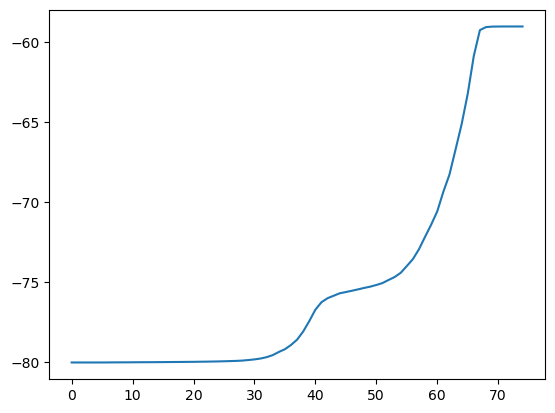

In [64]:
normalised_area_cumsum = A_sum.cumsum('ht_bin')/np.nansum(A_sum)
normalised_area_cumsum_u = Au_sum.cumsum('hu_bin')/np.nansum(Au_sum)

pseudo_lat = -1*(80-(80-59)*normalised_area_cumsum)
plt.plot(pseudo_lat.values)

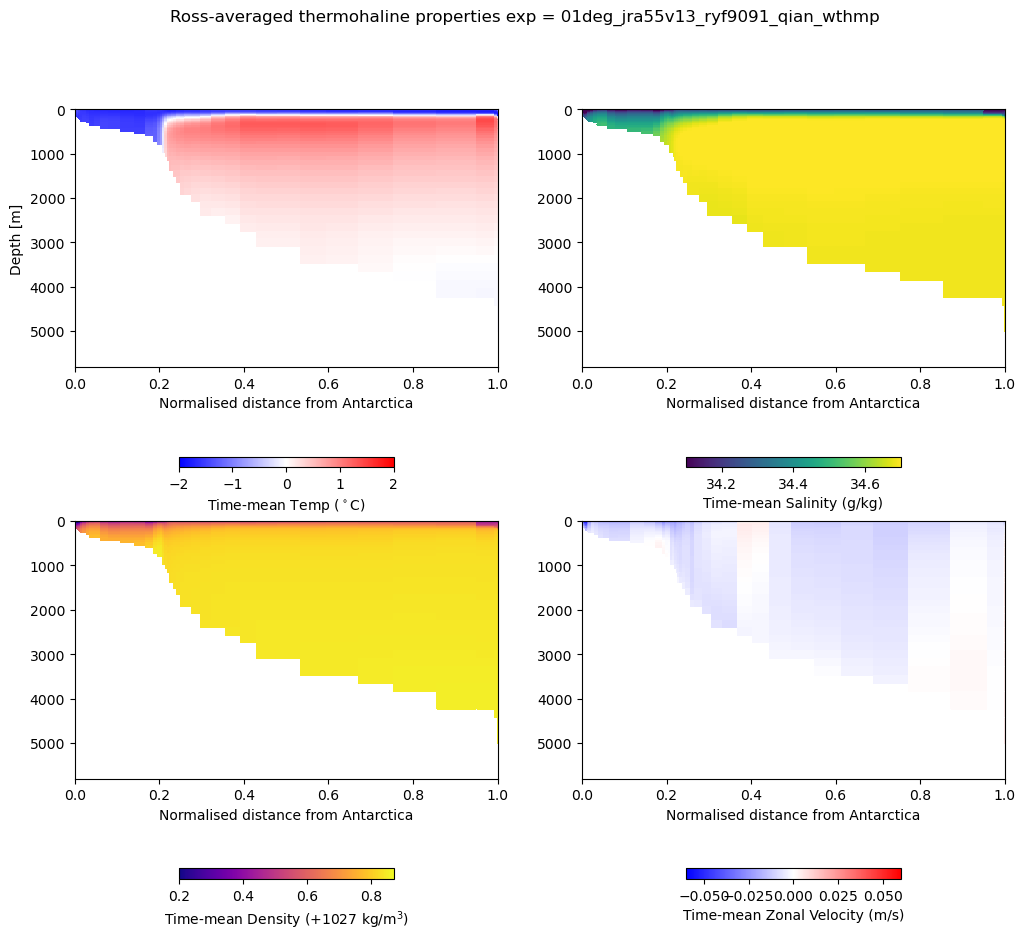

In [65]:
# dec 30
fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()


im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean.mean('time'), vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].pcolor(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Normalised distance from Antarctica')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.25, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

plt.suptitle('Ross-averaged thermohaline properties exp = ' + expt)
plt.show()

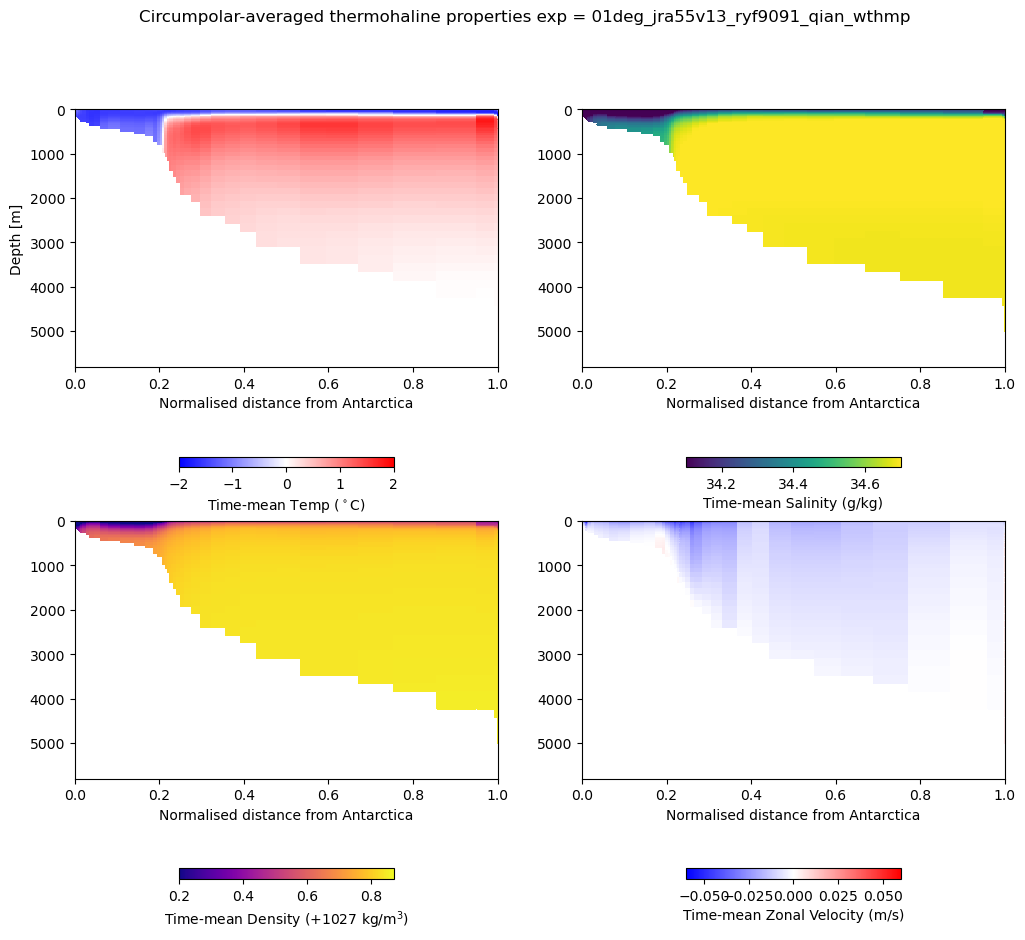

In [45]:
# dec 50
fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()


im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean.mean('time'), vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].pcolor(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Normalised distance from Antarctica')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.25, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

plt.suptitle('Ross-averaged thermohaline properties exp = ' + expt)
plt.show()

In [67]:
'''
T_mean.to_netcdf('T_mean_Ross_dec50.nc') # year 2150-2159
S_mean.to_netcdf('S_mean_Ross_dec50.nc')
#rho_mean.to_netcdf('rho_Ross_mean_dec50.nc')
#u_mean.to_netcdf('u_mean_Ross_dec50.nc')
'''
T_mean.to_netcdf('T_mean_Ross_dec30.nc') # year 2130-2140
S_mean.to_netcdf('S_mean_Ross_dec30.nc')
#rho_mean.to_netcdf('rho_mean_Ross_dec30.nc')
#u_mean.to_netcdf('u_mean_Ross_dec30.nc')
'''
T_mean.to_netcdf('T_mean_dec0.nc') # year 2110-2120
S_mean.to_netcdf('S_mean_dec0.nc')
rho_mean.to_netcdf('rho_mean_dec0.nc')
u_mean.to_netcdf('u_mean_dec0.nc')
'''

"\nT_mean.to_netcdf('T_mean_dec0.nc') # year 2110-2120\nS_mean.to_netcdf('S_mean_dec0.nc')\nrho_mean.to_netcdf('rho_mean_dec0.nc')\nu_mean.to_netcdf('u_mean_dec0.nc')\n"

In [43]:
T_mean.ht_bin

<xarray.DataArray 'ht_bin' (ht_bin: 75)> Size: 600B
array([5.412808e-01, 1.680735e+00, 2.939953e+00, 4.331521e+00, 5.869350e+00,
       7.568810e+00, 9.446885e+00, 1.152234e+01, 1.381593e+01, 1.635055e+01,
       1.915154e+01, 2.224687e+01, 2.566746e+01, 2.944746e+01, 3.362460e+01,
       3.824057e+01, 4.334140e+01, 4.897796e+01, 5.520640e+01, 6.208874e+01,
       6.969342e+01, 7.809601e+01, 8.737988e+01, 9.763700e+01, 1.089687e+02,
       1.214869e+02, 1.353144e+02, 1.505868e+02, 1.674530e+02, 1.860765e+02,
       2.066365e+02, 2.293296e+02, 2.543701e+02, 2.819920e+02, 3.124492e+02,
       3.460166e+02, 3.829906e+02, 4.236883e+02, 4.684475e+02, 5.176242e+02,
       5.715899e+02, 6.307275e+02, 6.954248e+02, 7.660668e+02, 8.430255e+02,
       9.266482e+02, 1.017244e+03, 1.115068e+03, 1.220309e+03, 1.333076e+03,
       1.453384e+03, 1.581154e+03, 1.716205e+03, 1.858264e+03, 2.006975e+03,
       2.161913e+03, 2.322601e+03, 2.488533e+03, 2.659189e+03, 2.834054e+03,
       3.012631e+03, 3.194453e+03, 3.379089e+03, 3.566145e+03, 3.755274e+03,
       3.946166e+03, 4.138551e+03, 4.332197e+03, 4.526903e+03, 4.722497e+03,
       4.918835e+03, 5.115794e+03, 5.313270e+03, 5.511177e+03, 5.709443e+03])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

# Plotting all times with importing

In [13]:
pwd

'/g/data/v45/qo9901/MW-perturb-ASC-data'

In [14]:
T_mean_50 = xr.open_mfdataset('T_mean_Ross_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2150-2159
S_mean_50 = xr.open_mfdataset('S_mean_Ross_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_50 = xr.open_mfdataset('rho_mean_Ross_dec50.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
u_mean_50 = xr.open_mfdataset('u_mean_Ross_dec50.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )

T_mean_30 = xr.open_mfdataset('T_mean_Ross_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2130-2140
S_mean_30 = xr.open_mfdataset('S_mean_Ross_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_30 = xr.open_mfdataset('rho_mean_Ross_dec30.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
u_mean_30 = xr.open_mfdataset('u_mean_Ross_dec30.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )
'''
T_mean_0 = xr.open_mfdataset('T_mean_Ross_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2110-2120
S_mean_0 = xr.open_mfdataset('S_mean_Ross_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_0 = xr.open_mfdataset('rho_mean_Ross_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
u_mean_0 = xr.open_mfdataset('u_mean_Ross_dec0.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )
'''

"\nT_mean_0 = xr.open_mfdataset('T_mean_Ross_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) ) # year 2110-2120\nS_mean_0 = xr.open_mfdataset('S_mean_Ross_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )\nrho_mean_0 = xr.open_mfdataset('rho_mean_Ross_dec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )\nu_mean_0 = xr.open_mfdataset('u_mean_Ross_dec0.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )\n"

In [15]:
def fmt(x):
    s = f"{x:.2f}"
    #if s.endswith("0"):
    #    s = f"{x:.0f}"
    return rf"{s} \m/s" if plt.rcParams["text.usetex"] else f"{s} m/s"
'''
def fmt_rho(x):
    s = f"{x:.2f}"
    #if s.endswith("0"):
    #    s = f"{x:.0f}"
    return rf"{s} kg/m$^{3}$" if plt.rcParams["text.usetex"] else f"{s} kg/m$^{3}$"
'''
def fmt_rho(x):
    s = f"{x:.2f}"
    #if s.endswith("0"):
    #    s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s} "


In [16]:
from matplotlib import rc
rc('font', **{'size':35})
rc('text', usetex=False)
rc('xtick', labelsize=35) #20 
rc('ytick', labelsize=35) #20
rc('axes', titlesize=35)    # fontsize of the axes title
rc('axes', labelsize=35) #24    # fontsize of the x and y labels

In [17]:
def plot_topography_isobath(bins_isobath, ax):
    # Example topography and distance arrays
    '''
    topography = generate_cross_section_depth(hu_region.drop(['geolon_c', 'geolat_c']),\
                                               shelf_coord, depth_coord) # Replace with actual topography data
    topography = topography.to_dataframe().set_index(['distance']).to_xarray().hu
    
    distance = u_section.distance  # Replace with actual distance data
    '''
    ax.plot(normalised_area_cumsum, bins_isobath[:60],color = 'g',lw = 4)
                            
    # Specified depth
    specified_depth = 600  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='g', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
    # Specified depth
    specified_depth = 200  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='gray', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
    
    # Specified depth
    specified_depth = 1000  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='gray', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
      # Specified depth
    specified_depth = 2500  # Example: depth in meters
    
    # Find the index where the topography is closest to the specified depth
    #index = np.argmin(np.abs(topography - specified_depth))
    index = np.abs(bins_isobath - specified_depth).argmin()#.values#kipna = True
    normalised_area_cumsum_depth = normalised_area_cumsum[index]
    
    ax.axvline(x=normalised_area_cumsum_depth, color='g', lw =4 ,linestyle='--', label=f'Depth: {specified_depth}m')
    return

In [20]:
normalised_area_cumsum = A_sum.sel(ht_bin = slice(0,3000)).cumsum('ht_bin')/np.nansum(A_sum.sel(ht_bin = slice(0,3000)))
normalised_area_cumsum_u = Au_sum.sel(hu_bin = slice(0,3000)).cumsum('hu_bin')/np.nansum(Au_sum.sel(hu_bin = slice(0,3000)))


In [21]:
st_ocean = st_ocean.sel(st_ocean = slice(0,3000))

## getting control age - skip

In [66]:
expt = '01deg_jra55v13_ryf9091'
start_time='2110-01-01 00:00:00'
end_time='2119-12-31 00:00:00'

age = cc.querying.getvar(expt, 'age_global', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
age = age.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)

ageV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*age)
age_mean = ageV_sum/V_sum
#age_mean.load()


u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice_ross, xu_ocean = lon_slice_ross)

uV_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u)
u_mean = uV_sum/Vu_sum
#u_mean.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [68]:
u_mean.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

<xarray.DataArray 'histogram_hu' (st_ocean: 75, time: 117, hu_bin: 75)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * hu_bin   (hu_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

In [72]:
u_mean.to_netcdf('u_mean_Ross_ctrldec0.nc') # year 2110-2120


In [70]:
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time , attrs={'cell_methods': 'time: mean'}, frequency='1 monthly')#, ncfile="ocean.nc")
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)
TV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*temp)
T_mean = TV_sum/V_sum

salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time , frequency='1 monthly')#, ncfile="ocean.nc")
salt = salt.sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)
SV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*salt)
S_mean = SV_sum/V_sum

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [25]:
V_sum.load()

<xarray.DataArray 'histogram_ht' (st_ocean: 75, ht_bin: 75)> Size: 45kB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.02757032e+11, 1.21208277e+11, 8.43952823e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.97643092e+11, 1.33948112e+11, 9.32658151e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.10250151e+12, 1.48026881e+11, 1.03068625e+10],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.95398939e+13, 2.21366477e+13, 1.54133751e+12],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.15238881e+12, 1.54438807e+12],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.63482317e+12, 6.39568553e+11]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean

In [75]:
S_mean.load()
S_mean.to_netcdf('S_mean_Ross_ctrldec0.nc')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

In [76]:
temp.isel(time = 0)#.load()

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 355, xt_ocean: 500)> Size: 53MB
dask.array<getitem, shape=(75, 355, 500), dtype=float32, chunksize=(7, 273, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 4kB -199.9 -199.8 -199.7 ... -150.2 -150.1
  * yt_ocean  (yt_ocean) float64 3kB -79.97 -79.93 -79.88 ... -65.06 -65.02
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      object 8B 2110-01-16 12:00:00
Attributes: (12/13)
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ...             ...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [79]:
T_mean.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

<xarray.DataArray 'histogram_ht' (st_ocean: 75, time: 120, ht_bin: 75)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

In [80]:
T_mean.to_netcdf('T_mean_Ross_ctrldec0.nc')

In [98]:
density = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time )#, ncfile="ocean.nc")
density = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice_ross, xt_ocean = lon_slice_ross)
rhoV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*density)
rho_mean = rhoV_sum/V_sum

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [99]:
rho_mean.load()

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-4015102' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:2391> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py", line 2400, in wait
    raise AllExit()
distributed.client.AllExit
ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-4015103' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:2391> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py", line 2400, in wait
    raise AllExit()
distributed.client.AllExit
ERRO

<xarray.DataArray 'histogram_ht' (st_ocean: 75, time: 120, ht_bin: 75)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * ht_bin   (ht_bin) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Dimensions without coordinates: st_ocean, time

In [100]:
rho_mean.to_netcdf('rho0_mean_Ross_ctrldec0.nc')

In [22]:
u_mean_ctrl_0 = xr.open_mfdataset('u_mean_Ross_ctrldec0.nc').sel(hu_bin = slice(0,3000), st_ocean = slice(0,60) )
rho_mean_ctrl_0 = xr.open_mfdataset('rho0_mean_Ross_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
S_mean_ctrl_0 = xr.open_mfdataset('S_mean_Ross_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )
T_mean_ctrl_0 = xr.open_mfdataset('T_mean_Ross_ctrldec0.nc').sel(ht_bin = slice(0,3000), st_ocean = slice(0,60) )

In [23]:
#age_mean.to_netcdf('age_mean_ctrldec0.nc') # year 2110-2120
#age_mean.to_netcdf('age_mean_ctrldec30.nc') # year 2130-2140
#age_mean.to_netcdf('age_mean_ctrldec50.nc') # year 2150-2160


# Final plots

In [24]:
import cmocean

In [25]:

vmin_rho = 0.7
vmax_rho = 0.8
levels_rho = np.linspace(vmin_rho, vmax_rho,3)
levels_rho

array([0.7 , 0.75, 0.8 ])

[0.7  0.75 0.8 ]
[0.7  0.75 0.8 ]
[0.7  0.75 0.8 ]
[0.7  0.75 0.8 ]
[0.7  0.75 0.8 ]


Text(0.07, 2700, '(i)')

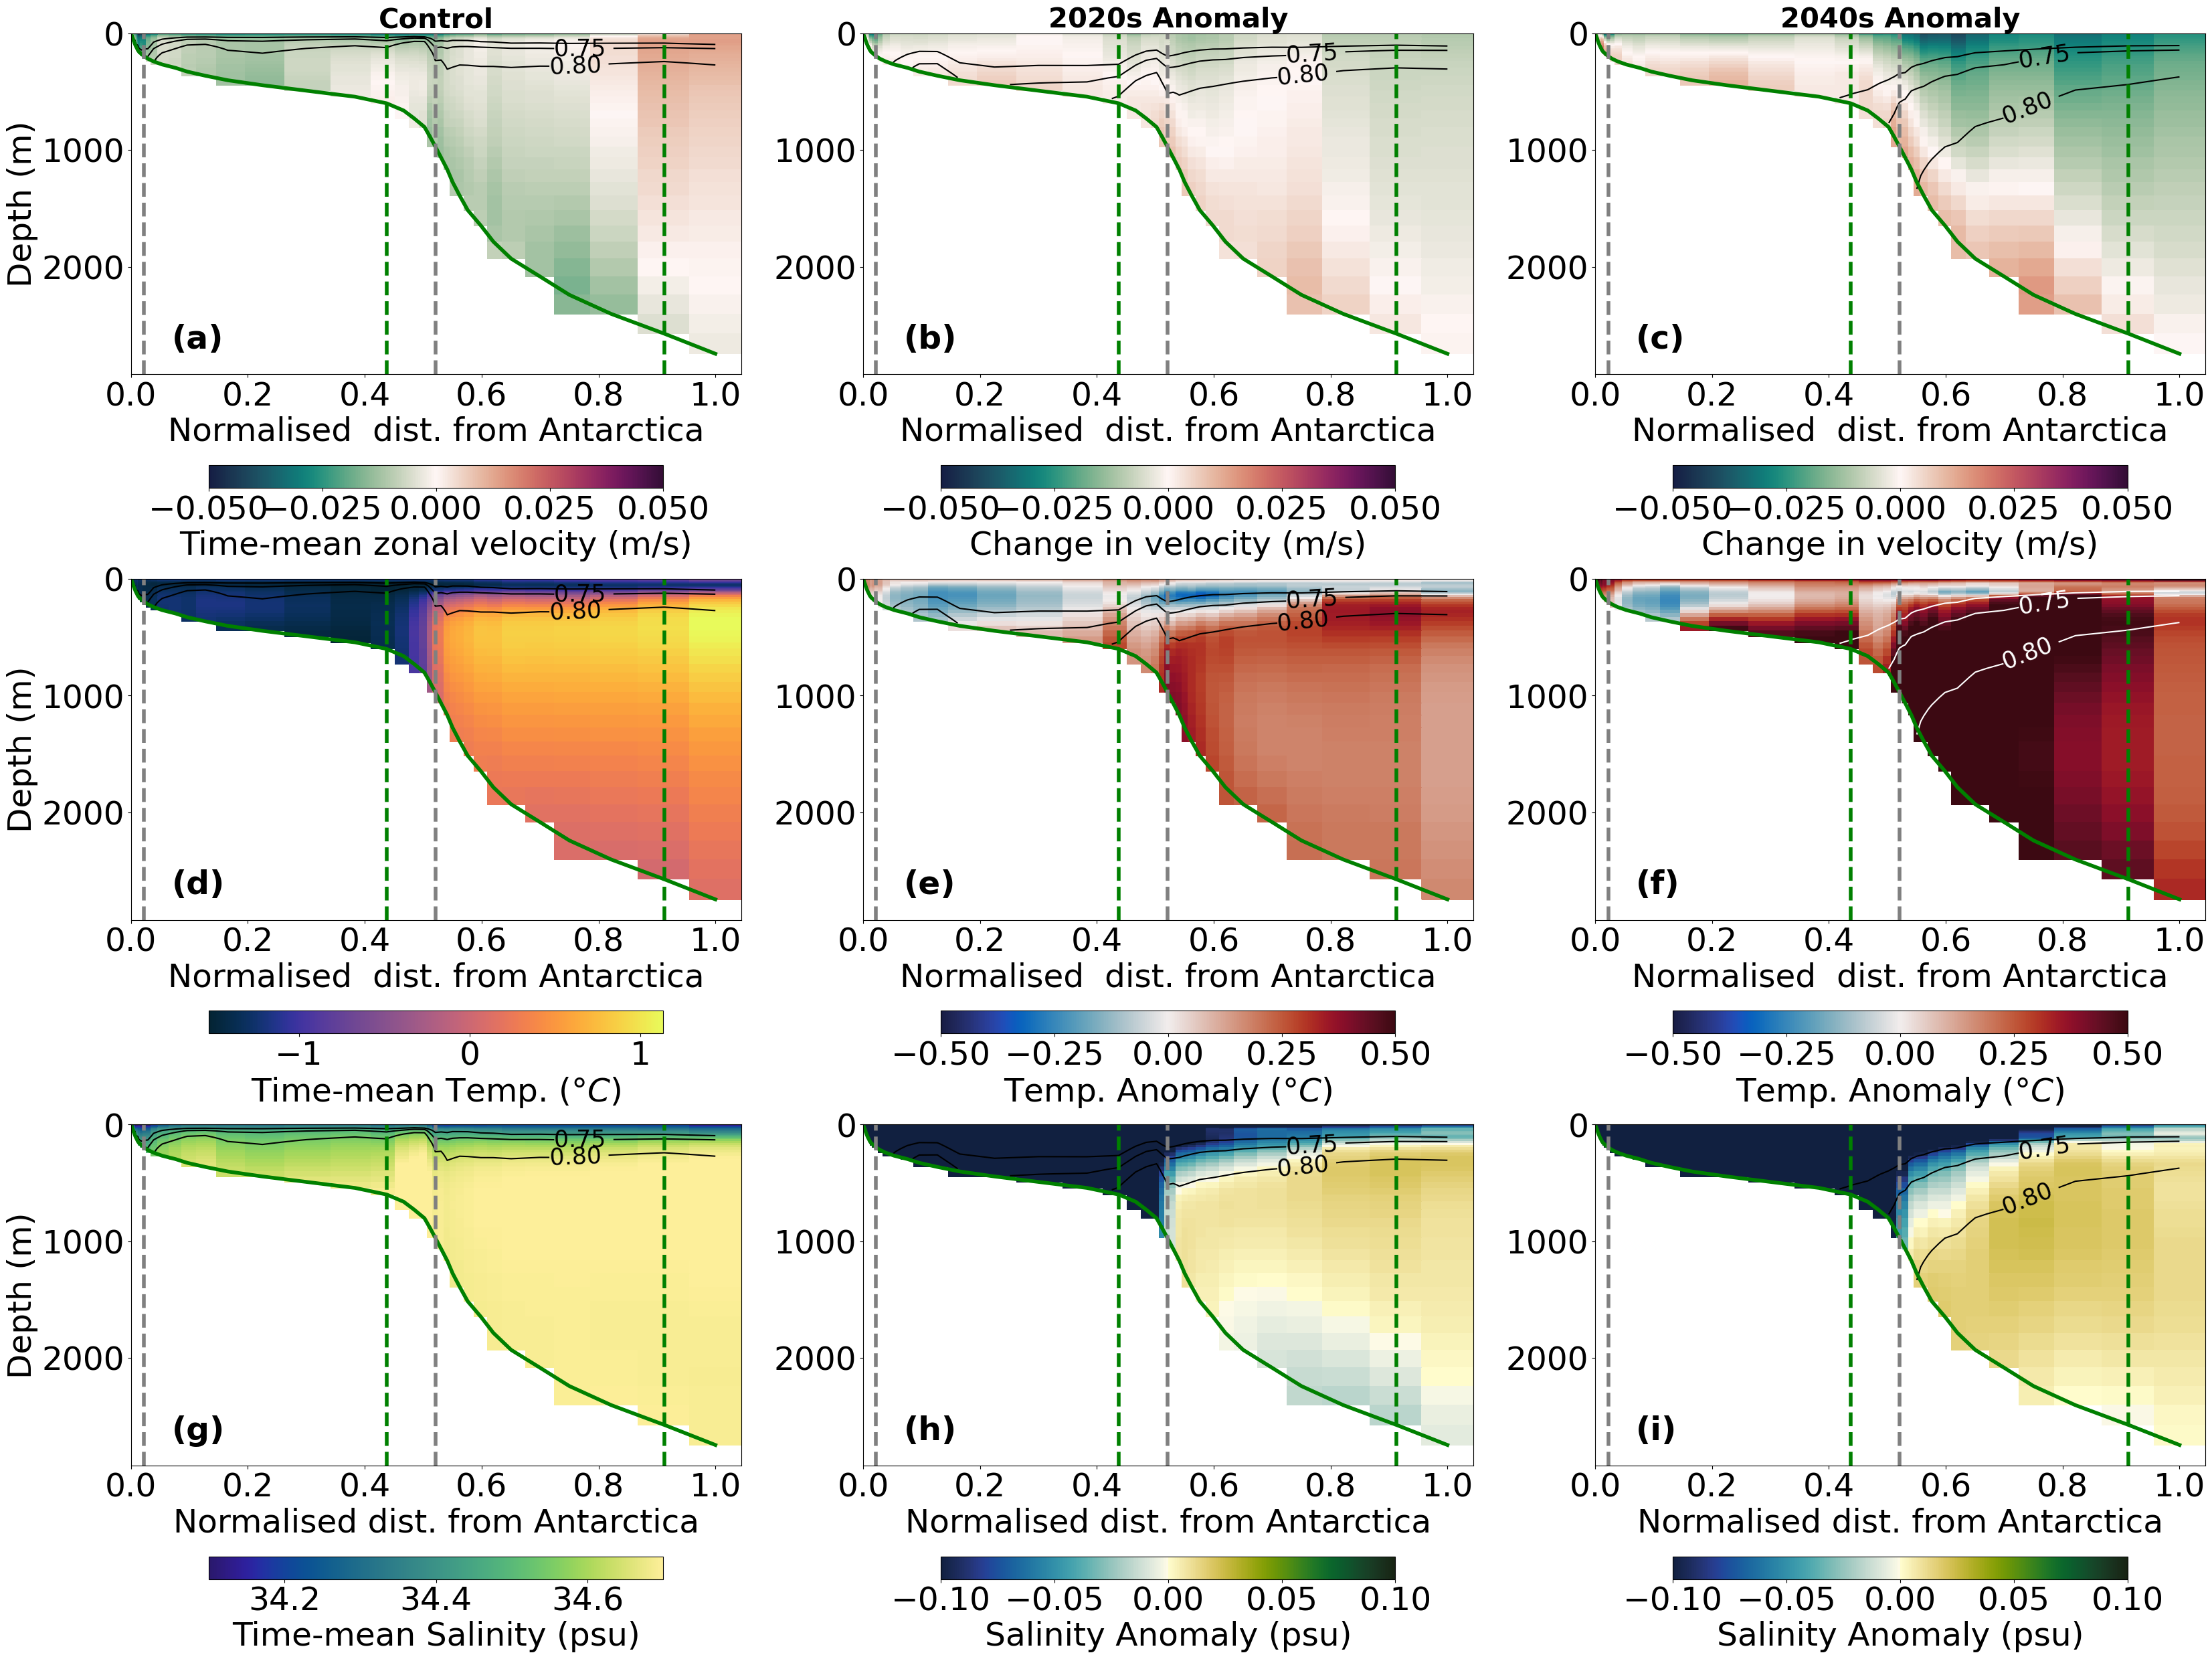

In [27]:
fig, axs = plt.subplots(ncols = 3,nrows = 3, figsize=(40,30), facecolor='w', edgecolor='k')

#########

vmin_rho = 0.7
vmax_rho = 0.8
vmin_u = -0.05
vmax_u = 0.05
fontsize = 25
lw = 5
levels_rho = np.linspace(vmin_rho, vmax_rho,3)
levels_u = np.linspace(vmin_u, vmax_u,11)
manual_locations = [(0.775,200) ,(0.775,1000)]
color_clabel = 'k'

########## ZONAL VELOCITY

im1 = axs[0,0].pcolor(normalised_area_cumsum, st_ocean, u_mean_ctrl_0.mean('time').histogram_hu.values , vmin = vmin_u, vmax = vmax_u, cmap=cmocean.cm.curl)
cb2 = plt.colorbar(im1, ax=axs[0,0], fraction=0.05, pad=0.2,  orientation = 'horizontal')
cb2.set_label('Time-mean zonal velocity (m/s)')


im2 = axs[0,1].pcolor(normalised_area_cumsum, st_ocean, (u_mean_30.mean('time').histogram_hu.values - u_mean_ctrl_0.mean('time').histogram_hu.values), \
                    vmin = vmin_u, vmax = vmax_u, cmap=cmocean.cm.curl)
cb2 = plt.colorbar(im2, ax=axs[0,1], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Change in velocity (m/s)')

im3 = axs[0,2].pcolor(normalised_area_cumsum, st_ocean, (u_mean_50.mean('time').histogram_hu.values - u_mean_ctrl_0.mean('time').histogram_hu.values),  \
                    vmin = vmin_u, vmax = vmax_u, cmap=cmocean.cm.curl)
cb2 = plt.colorbar(im3, ax=axs[0,2], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Change in velocity (m/s)')


CS = axs[0,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors =color_clabel)
kwargs = {'inline_spacing' : 0, 'inline': True, 'use_clabeltext' : True, 'fontsize':fontsize, 'manual' : manual_locations}#, 'fontweight':'bold'}
axs[0,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[0,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[0,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)

CS = axs[0,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[0,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

axs[0,0].set_title('Control', fontweight = 'bold',fontsize = 30)
axs[0,1].set_title('2020s Anomaly', fontweight = 'bold',fontsize = 30)
axs[0,2].set_title('2040s Anomaly', fontweight = 'bold',fontsize = 30)

for i in range(3):
    axs[0,i].set_xlabel('Normalised  dist. from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[0,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[0,i])

####### temp

im1 = axs[1,0].pcolor(normalised_area_cumsum, st_ocean, T_mean_ctrl_0.mean('time').histogram_ht.values -273 , cmap=cmocean.cm.thermal)
cb2 = plt.colorbar(im1, ax=axs[1,0], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Time-mean Temp. ($\degree C$)')

im2 = axs[1,1].pcolor(normalised_area_cumsum, st_ocean,(T_mean_30.mean('time').histogram_ht.values - T_mean_ctrl_0.mean('time').histogram_ht.values), \
                    vmin = -0.5, vmax = 0.5, cmap=cmocean.cm.balance)
cb2 = plt.colorbar(im2, ax=axs[1,1], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Temp. Anomaly ($\degree C$)')

im3 = axs[1,2].pcolor(normalised_area_cumsum, st_ocean,(T_mean_50.mean('time').histogram_ht.values - T_mean_ctrl_0.mean('time').histogram_ht.values),  \
                    vmin = -0.5, vmax = 0.5, cmap=cmocean.cm.balance)
cb2 = plt.colorbar(im3, ax=axs[1,2], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Temp. Anomaly ($\degree C$)')

# temp
CS = axs[1,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho,colors = color_clabel)
axs[1,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[1,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho,colors = color_clabel)
axs[1,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

CS = axs[1,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = 'w')
axs[1,2].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)
print(CS.levels)

for i in range(3):
    axs[1,i].set_xlabel('Normalised  dist. from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[1,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[1,i])

########## salinty
im1 = axs[2,0].pcolor(normalised_area_cumsum, st_ocean, S_mean_ctrl_0.mean('time').histogram_ht.values, vmin=34.1, vmax = 34.7, cmap=cmocean.cm.haline)
cb2 = plt.colorbar(im1, ax=axs[2,0], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Time-mean Salinity (psu)')


im2 = axs[2,1].pcolor(normalised_area_cumsum, st_ocean, S_mean_30.mean('time').histogram_ht.values - S_mean_ctrl_0.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=cmocean.cm.delta)
cb2 = plt.colorbar(im2, ax=axs[2,1], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Salinity Anomaly (psu)')

im3 = axs[2,2].pcolor(normalised_area_cumsum, st_ocean, S_mean_50.mean('time').histogram_ht.values - S_mean_ctrl_0.mean('time').histogram_ht.values, vmin=-0.1, vmax = 0.1, cmap=cmocean.cm.delta)
cb2 = plt.colorbar(im3, ax=axs[2,2], fraction=0.05, pad=0.2, orientation = 'horizontal')
cb2.set_label('Salinity Anomaly (psu)')


CS = axs[2,0].contour(normalised_area_cumsum, st_ocean, rho_mean_ctrl_0.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[2,0].clabel(CS, CS.levels,fmt= fmt_rho, **kwargs)

CS = axs[2,1].contour(normalised_area_cumsum, st_ocean, rho_mean_30.mean('time').histogram_ht.values-1027,  levels = levels_rho ,vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[2,1].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)

CS = axs[2,2].contour(normalised_area_cumsum, st_ocean, rho_mean_50.mean('time').histogram_ht.values-1027,  levels = levels_rho , vmin=vmin_rho, vmax=vmax_rho, colors = color_clabel)
axs[2,2].clabel(CS, CS.levels,fmt= fmt_rho,  **kwargs)
print(CS.levels)
for i in range(3):
    axs[2,i].set_xlabel('Normalised dist. from Antarctica')
    #axs[i].set_ylim([0,3000])
    axs[2,i].invert_yaxis()
    plot_topography_isobath(bins_isobath, axs[2,i])
    axs[i,0].set_ylabel('Depth (m)')
    
axs[0,0].text(0.07,2700,'(a)', fontweight = 'bold')
axs[0,1].text(0.07,2700,'(b)', fontweight = 'bold')
axs[0,2].text(0.07,2700,'(c)', fontweight = 'bold')
axs[1,0].text(0.07,2700,'(d)', fontweight = 'bold')
axs[1,1].text(0.07,2700,'(e)', fontweight = 'bold')
axs[1,2].text(0.07,2700,'(f)', fontweight = 'bold')
axs[2,0].text(0.07,2700,'(g)', fontweight = 'bold')
axs[2,1].text(0.07,2700,'(h)', fontweight = 'bold')
axs[2,2].text(0.07,2700,'(i)', fontweight = 'bold')


#plt.tight_layout()